In [3]:
%load_ext autoreload
%matplotlib inline  
%autoreload 
__author__ = 'ewan'
import numpy as np
# print '\nBackend:\n' + mpl.get_backend() + '\n'

import sys
sys.path.append("../src/") 

import WindFarm as wf
import WindTurbine as wt
#import matplotlib.pyplot as plt
from DWM_flowfield_farm import DWM_main_field_model
from DWM_init_dict import init
from math import pi, sqrt, isnan
from DWM_GClarsenPicks import get_Rw_NOJ, gaussN, get_Rw, get_R96, Ua, Ua_shear
import time
from scipy import io, interpolate
from DWM_misc import smooth, to_bool
import matplotlib.pylab as plt
import matplotlib._cntr as cntr
import multiprocessing


def sDWM(derating,**kwargs):
#     WD,WS,TI,WTcoord,WTG,HH,R,stab,accum,optim,
    WD = kwargs.get('WD')
    WS = kwargs.get('WS')
    TI = kwargs.get('TI') 
    WTcoord = kwargs.get('WTcoord') 
    WTG = kwargs.get('WTG') 
    HH = kwargs.get('HH') 
    R = kwargs.get('R') 
    stab = kwargs.get('stab') 
    accum = kwargs.get('accum') 
    optim = to_bool(kwargs.get('optim'))
    
#     print '************************** Run DWM model ******************'
#     print '***********************************************************'
#     print '***********************************************************'
    ttt = time.time()
    # WT = wt.WindTurbine('Vestas v80 2MW offshore','V80_2MW_offshore.dat',70,40)
    # WF = wf.WindFarm('Horns Rev 1','HR_coordinates.dat',WT)
    WT = wt.WindTurbine('Windturbine','../WT-data/'+WTG+'/'+WTG+'_PC.dat',HH,R)
    WF = wf.WindFarm('Windfarm',WTcoord,WT)
    if optim is True:
        print 'Performing optimization'
        WT.CP = np.load('../WT-data/'+WTG+'/'+WTG+'_CP.npy')
        WT.CT = np.load('../WT-data/'+WTG+'/'+WTG+'_CT.npy')
        WT.lambdaf3=WT.CP[:,:,0]
        WT.PITCH3=WT.CP[:,:,1]
        WT.CP3=WT.CP[:,:,2]
        WT.CT3=WT.CT[:,:,2]
        WT.CP3[WT.CP3>(16./27.)]=0
        WT.CP3[np.isnan(WT.CP3)]=0
        WT.CT3[np.isnan(WT.CT3)]=0
        WT.CPc = cntr.Cntr(WT.PITCH3,WT.lambdaf3,WT.CP3)
        WT.CTc=cntr.Cntr(WT.PITCH3,WT.lambdaf3,WT.CT3)
        # WT.CPcurve= np.load('WT-data/'+WTG+'/BEM/CPcurve.npy')
        # WT.CTcurve= np.load('WT-data/'+WTG+'/BEM/CTcurve.npy')
        # WT.getCTCP= interpolator(WT.CPcurve,WT.CTcurve)
    elif optim is False:
        print 'Not Performing optimization'
        derating=1.0*np.ones((WF.nWT))
        WT.CP = None
        WT.CT = None

#     print 'Derating are', derating
    #WT = wt.WindTurbine('NREL 5 MW','NREL_5MW.dat',90,63.0)

    # Scaling wind farm to NREL's rotor size
    if 'Lill' in WTcoord:
        WF.vectWTtoWT=WF.vectWTtoWT*(WT.R/46.5) # 46.5 is the Lillgrund nominal radius of SWT turbine
    # Compute distance WT to WT in mean flow coordinate system
    distFlowCoord, nDownstream, id0= WF.turbineDistance(WD)

    # Init dictionnaries
    deficits, turb, inlets_ffor, inlets_ffor_deficits,inlets_ffor_turb,out, DWM, ID_waked, ID_wake_adj, Farm_p_out, WT_p_out, Vel_out,WT_pitch_out,WT_RPM_out=init(WF)

    # Extreme wake to define WT's in each wake, including partial wakes
    ID_wake = {id0[i]:(get_Rw(x=distFlowCoord[0,id0[i],:],\
                              R=2.*WF.WT.R,TI=TI,CT=WT.get_CT(WS),pars=[0.435449861,0.797853685,-0.124807893,0.136821858,15.6298,1.0])>\
               np.abs(distFlowCoord[1,id0[i],:])).nonzero()[0] \
               for i in range(WF.nWT)}
    # Power output list
    Farm_p_out=0.
    WT_p_out=np.zeros((WF.nWT))
    WT_pitch_out=np.zeros((WF.nWT,2))
    WT_RPM_out=np.zeros((WF.nWT,2))
    Vel_out=np.zeros((WF.nWT))
    # print ID_wake
    # fig,ax=WF.plot(WT_num=True)
    # fig.hold('True')
    # plt.show()

    for iT in range(WF.nWT):
        # Define flow case geometry
        cWT = id0[iT]
        #Radial coordinates in cWT for wake affected WT's
        x=distFlowCoord[0,cWT,ID_wake[cWT]]
        C2C   = distFlowCoord[1,cWT,ID_wake[cWT]]

        index_orig=np.argsort(x)
        x=np.sort(x)
        row= ID_wake[id0[iT]][index_orig]
        C2C=C2C[index_orig]

        # Wrapping the DWM core model with I/O
        par={
         'WS':WS,
         'TI':TI,
         'atmo_stab':stab,
         'WTG':'NY2',      #'WTG':'NREL5MW',
         'WTG_spec': WT,
         'wtg_ind': row, # turbine index
         'hub_z':x/(2*WF.WT.R), # compute the flow field at downstream location of each downwind turbine !
         'hub_x': np.ceil((3*(max(abs(C2C))+WF.WT.R))/WF.WT.R)*0.5+C2C/(WF.WT.R), # lateral offset of each downwind turbine with respect to the most upstream turbine in the tree
         'C2C': C2C, # center 2 center distances between hubs
         'lx':np.ceil((3.*(max(abs(C2C))+WF.WT.R))/WF.WT.R), # length of the domain in lateral
         'ly':np.ceil((3.*(max(abs(C2C))+WF.WT.R))/WF.WT.R),  # length of the domain in longitudinal in D
         # 'wake_ind_setting':1,
         'accu_inlet': True,
         'derating': derating[row[0]],
         'optim': optim,
         'accu': accum, # type of wake accumulation
         'full_output': True # Flag for generating the complete output with velocity deficit
        }

        ID_wake_adj[str(id0[iT])]=row
        aero, meta, mfor, ffor, DWM, deficits,inlets_ffor,inlets_ffor_deficits, inlets_ffor_turb,turb, out,ID_waked = DWM_main_field_model(ID_waked,deficits,inlets_ffor,inlets_ffor_deficits,inlets_ffor_turb,turb,DWM,out,**par)
        # Total power
        Farm_p_out= Farm_p_out+out[str(meta.wtg_ind[0])][0] # based on BEM
        # Power by each turbine
        WT_p_out[iT]=out[str(meta.wtg_ind[0])][0]
        # Pitch and RPM
        WT_pitch_out[iT,0]=aero.PITCH
        WT_pitch_out[iT,1]=aero.PITCH_opt
        WT_RPM_out[iT,0]=aero.RPM
        WT_RPM_out[iT,1]=aero.RPM_opt
        Vel_out[iT]=out[str(meta.wtg_ind[0])][1]    
    elapsedttt = time.time() - ttt
    print 'Total run  for wind direction %i is %4.2f sec' %(WD,elapsedttt)
    # filename='outputs/dwm_WS_'+ str(WS) +'_dir_' + str(WD)+'_TI_' + str(TI)
    # filename.replace('.','_')
    # np.save(filename,out)
    # return aero, meta, mfor, ffor, DWM, deficits,inlets_ffor,inlets_ffor_deficits, turb, DWM, out, ID_waked, id0,ID_wake_adj
    print 'The farm production is: %4.2f kW, where each turbine is: %s' %(Farm_p_out,np.array_str(WT_p_out))
    # plt.close('all')
    return Farm_p_out,WT_p_out,WT_pitch_out,WT_RPM_out,Vel_out,DWM

    # filename='outputs/dwm_WS_'+ str(WS) +'_dir_' + str(WD)+'_TI_' + str(TI)
    # filename.replace('.','_')
    # np.save(filename,out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
inputs={'WD':120.0,
'WS':9.0,
'TI':0.06,
# WTcoord=''../data/Lill_A04B04C04.dat''
'WTcoord':'../data/Lill_A04.dat',
'WTG':'NY2',
# 'WTG':'NREL5MW',
'HH':65.0,
'R':46.5,
'stab':'N',
'accum':'dominant',
'optim':True}

WD = inputs.get('WD')
WS = inputs.get('WS')
TI = inputs.get('TI') 
WTcoord = inputs.get('WTcoord') 
WTG = inputs.get('WTG') 
HH = inputs.get('HH') 
R = inputs.get('R') 
stab = inputs.get('stab') 
accum = inputs.get('accum') 
optim = to_bool(inputs.get('optim'))
    
    
WT = wt.WindTurbine('Windturbine','../WT-data/'+WTG+'/'+WTG+'_PC.dat',HH,R)
WF = wf.WindFarm('Windfarm',WTcoord,WT)

# spec=pd.read_csv('WT-data/'+WTG+'/'+WTG+'_Spec.dat',delim_whitespace=True,names=['ws', 'rpm', 'pitch'], header=10)
# print spec

Pref,Tref,Pitchref,RPMref,Vel_outref,DWM= sDWM([1.,1.],**inputs)


Performing optimization
Total run  for wind direction 120 is 0.36 sec
The farm production is: 1866.89 kW, where each turbine is: [ 1386.77   480.12]


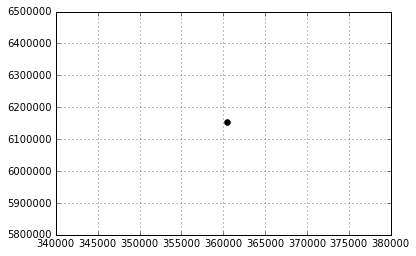

In [5]:
# %matplotlib inline 
import pandas as pd
coord=pd.read_csv('../data/Lill_A04.dat',delim_whitespace=True,names=['x', 'y'], header=0)
plt.figure()
plt.plot(coord['x'],coord['y'],'ko')
plt.grid('on')
plt.show()

In [6]:
# Investigate step response for very small variation of deratings
# vTI=[0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.10,0.11,0.12,0.13,0.14,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15]

# vDe=np.arange(0.05,0.62,0.001)
vDe=np.arange(0.01,0.63,0.005)
# vW=np.arange(4.,25.5,1.)
# vDe=np.asarray([0.50,0.75])
vW=np.array([9.,])
# Cs_out=np.zeros(  (   4.   ,    len(vW)  ,  len(vDe)  ))
# Ptot_out=np.zeros(  (   len(vW)  ,  len(vDe)  ))

Ptots=np.zeros((   len(vW)  ,  len(vDe)  ))
Trefs=np.zeros(( WF.nWT,   len(vW)  ,  len(vDe)  ))
Pitchs=np.zeros(( WF.nWT,  len(vW)  ,  len(vDe) ))
Pitchs_opt=np.zeros(( WF.nWT,  len(vW)  ,  len(vDe) ))
RPMs=np.zeros(( WF.nWT,  len(vW)  ,  len(vDe) ))
RPMs_opt=np.zeros(( WF.nWT,  len(vW)  ,  len(vDe) ))
Vels_out=np.zeros(( WF.nWT,  len(vW)  ,  len(vDe) ))
DWMs=[l for l in range(len(vDe))]
TI=0.06
k1=0
for iWS in vW:
    k2=0
    for iDe in vDe:
        inputs={'WD':120.0,
        'WS':iWS,
#         'TI':vTI[int(iWS)-4],
        'TI':TI,
        # WTcoord='Lill_coordinates.dat'
        'WTcoord':'../data/Lill_A04.dat',
        'WTG':'NY2',
        'HH':65.0,
        'R':46.5,
        'stab':'N',
        'accum':'dominant',
        'optim':True}
        derating=[iDe,1.]
        print 'Run %s at wind speed %4.2f' %(derating,iWS)
        Pref,Tref,Pitchref,RPMref,Vel_out,DWM= sDWM(derating,**inputs)
#         print C_out
        Ptots[k1,k2]=Pref
        Trefs[:,k1,k2]=Tref
        Pitchs[:,k1,k2]=Pitchref[:,0]
        Pitchs_opt[:,k1,k2]=Pitchref[:,1]
        RPMs[:,k1,k2]=RPMref[:,0]
        RPMs_opt[:,k1,k2]=RPMref[:,1]
        Vels_out[:,k1,k2]=Vel_out
        DWMs[k2]=DWM
        k2=k2+1
    k1=k1+1


Run [0.01, 1.0] at wind speed 9.00
Performing optimization
Total run  for wind direction 120 is 0.97 sec
The farm production is: 1347.48 kW, where each turbine is: [   23.07  1324.41]
Run [0.014999999999999999, 1.0] at wind speed 9.00
Performing optimization
Total run  for wind direction 120 is 1.11 sec
The farm production is: 1351.47 kW, where each turbine is: [   34.56  1316.91]
Run [0.019999999999999997, 1.0] at wind speed 9.00
Performing optimization
Total run  for wind direction 120 is 1.19 sec
The farm production is: 1355.33 kW, where each turbine is: [   45.97  1309.36]
Run [0.024999999999999998, 1.0] at wind speed 9.00
Performing optimization
Total run  for wind direction 120 is 1.19 sec
The farm production is: 1359.20 kW, where each turbine is: [   57.41  1301.79]
Run [0.029999999999999999, 1.0] at wind speed 9.00
Performing optimization
Total run  for wind direction 120 is 1.18 sec
The farm production is: 1363.03 kW, where each turbine is: [   68.94  1294.09]
Run [0.034999999

In [7]:
dT1=np.asarray([])

for iT1 in vDe:
        dT1=np.append(dT1,iT1)

Ptotsf=Ptots.flatten()
Trefsf=Trefs.flatten()

# print '2d index', np.asarray(np.unravel_index(Ptots.argmax(), Ptots.shape))
opt_index= np.asarray(np.unravel_index(Ptots.argmax(), Ptots.shape))
print opt_index
Gainpower= 100*((max(Ptotsf)-Pref)/max(Ptotsf))
# print Trefs[:,opt_index[0],opt_index[1]]


# print dT1.shape
print 'Maximum power from optimization %4.2f/ max CP power %4.2f' %(max(Ptotsf) , Pref)
# print 'index', np.argmax(Ptotsf)
print 'Derating T1 at max power', dT1[np.argmax(Ptotsf)]
print 'Derating T1 at max cp', Tref[0]/WT.P_rated
print 'percentage of derating T1 at max power', 100*((Tref[0]/WT.P_rated-dT1[np.argmax(Ptotsf)])/(Tref[0]/WT.P_rated))
print 'Power yield gained from derating in %', Gainpower
print ' .... Power produced by 2 turbines at standard', Tref
print ' .... .Optimized power producted by 2 turbines', Trefs[:,opt_index[0],opt_index[1]]


[  0 114]
Maximum power from optimization 1897.30/ max CP power 1866.89
Derating T1 at max power 0.58
Derating T1 at max cp 0.602932441976
percentage of derating T1 at max power 3.80348449995
Power yield gained from derating in % 1.60280398461
 .... Power produced by 2 turbines at standard [ 1386.77   480.12]
 .... .Optimized power producted by 2 turbines [ 1334.11   563.19]


BokehJS successfully loaded.

0.241681679668


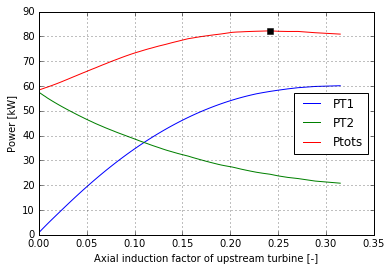

In [9]:
# plot the stuff
%matplotlib inline  
import bokeh
from bokeh.plotting import figure, show
bokeh.plotting.output_notebook()

# bokeh.plotting.output_file("layout.html")
# vDe=np.arange(0.125,1.25,0.125)
# vW=np.arange(4.,25.,0.25)
import colorsys
N= len(vDe)
HSV_tuples = [(xx*1.0/N, 0.5, 0.5) for xx in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
markers=['o','+','<','s','>','D','v','.']


# print Pitchs.shape
# plt.figure(figsize=(18,12))
# plt.subplot(2,2,1)
# p1 = figure(plot_width=250, plot_height=250)
# p1.line(100*(1.-(vDe/vDe[-1])),RPMs[0,0,:])      
# p1.circle(100*(1.-(vDe/vDe[-1])),RPMs[0,0,:], fill_color="white", size=8) 
# p1.line(100*(1.-(vDe/vDe[-1])),RPMs[1,0,:], color="olive")  
# p1.circle(100*(1.-(vDe/vDe[-1])),RPMs[1,0,:], color="olive", fill_color="white", size=8) 

#     plt.plot(vW,RPMs[1,:,k1],marker=None,color=RGB_tuples[k1] )      
# plt.plot(vW,RPMs_opt[0,:,0],'k--',label='Std')
# p.title('Control strategy RPM derating',fontsize=16)
# p.ylabel('RPM [-] ',fontsize=16)
# p.xlabel('Derating T1 [-]',fontsize=16)
# p.grid('on')
# p.legend(loc=2)


# p2 = figure(plot_width=250, plot_height=250)
# p2.line(100.*(1.-(vDe/vDe[-1])),Pitchs[0,0,:]) 
# p2.circle(100.*(1.-(vDe/vDe[-1])),Pitchs[0,0,:], fill_color="white", size=8) 
# p2.line(100.*(1.-(vDe/vDe[-1])),Pitchs[1,0,:], color="olive")  
# p2.circle(100.*(1.-(vDe/vDe[-1])),Pitchs[1,0,:],  color="olive",fill_color="white", size=8) 

#     plt.plot(vW,Pitchs[1,:,k1],marker=None,color=RGB_tuples[k1])     
# plt.plot(np.arange(4.,25.,0.5),Cs_out[3,:,0],'k--',label='Std')
# plt.title('Control strategy pitch derating',fontsize=16)
# plt.ylabel('Pitch [deg] ',fontsize=16)
# plt.xlabel('Derating T1 [-]',fontsize=16)
# plt.grid('on')
# plt.legend(loc=2)

# plt.subplot(2,2,3)

# for iP in vDe:
# p3 = figure(plot_width=250, plot_height=250)
# p3.line(100.*(1.-(vDe/vDe[-1])),Trefs[0,0,:])    
# p3.circle(100.*(1.-(vDe/vDe[-1])),Trefs[0,0,:], fill_color="white", size=8) 
# p3.line(100.*(1.-(vDe/vDe[-1])),Trefs[1,0,:], color="olive")
# p3.circle(100.*(1.-(vDe/vDe[-1])),Trefs[1,0,:], color="olive",fill_color="white", size=8) 
# p3.line(100.*(1.-(vDe/vDe[-1])),Ptots[0,:], color="red")
# p3.circle(100.*(1.-(vDe/vDe[-1])),Ptots[0,:], color="red",fill_color="white", size=8) 
# p = bokeh.io.gridplot([[p1, p2], [None, p3]])
# bokeh.plotting.show(p3)


## plot with axial induction

plt.figure()
# plt.subplot(1,3,1)
plt.plot([DWMs[l]['0'].mean_a for l in range(len(vDe))],Trefs[0,0,:]/Trefs[0,0,0],label='PT1')
plt.plot([DWMs[l]['0'].mean_a for l in range(len(vDe))],Trefs[1,0,:]/Trefs[0,0,0],label='PT2')
plt.plot([DWMs[l]['0'].mean_a for l in range(len(vDe))],Ptots[0,:]/Trefs[0,0,0],label='Ptots')
plt.plot([DWMs[l]['0'].mean_a for l in range(len(vDe))][np.argmax(Ptots[0,:])],np.amax(Ptots[0,:])/Trefs[0,0,0],'ks')
plt.xlabel('Axial induction factor of upstream turbine [-]')
plt.ylabel('Power [kW]')
plt.legend( loc=5)
plt.grid('on')

print [DWMs[l]['0'].mean_a for l in range(len(vDe))][np.argmax(Ptots[0,:])]


# plt.subplot(1,3,2)
# plt.plot()

# plt.hold(True)
#     plt.plot(vW,Trefs[1,:,k1],marker=None,color=RGB_tuples[k1])  
# plt.plot(np.arange(4.,25.,0.5),Cs_out[3,:,0],'k--',label='Std')
# plt.title('Derating: uptream power',fontsize=16)
# plt.ylabel('Power [kW] ',fontsize=16)
# plt.xlabel('Derating T1 [-]',fontsize=16)
# plt.grid('on')
# plt.legend(loc=2)

# plt.subplot(2,2,4)
# plt.plot(vW,Vels_out[0,:,1]-Vels_out[0,:,1],'k+',label='Std'  )      
# for iP in vDe:
# p= figure(plot_width=250, plot_height=400)
# p.line(100.*(1.-(vDe/vDe[-1])),100*(Vels_out[0,0,1]-Vels_out[1,0,:])/Vels_out[0,0,1]  )     
# p.circle(100.*(1.-(vDe/vDe[-1])),100*(Vels_out[0,0,1]-Vels_out[1,0,:])/Vels_out[0,0,1] , fill_color="white", size=8)
# bokeh.plotting.show(p)

# p = figure(plot_width=400, plot_height=400)
# p.line(100.*(1.-(vDe/vDe[-1])),Vels_out[1,0,:] )
# p.circle(100.*(1.-(vDe/vDe[-1])),Vels_out[1,0,:] , fill_color="white", size=8)
# bokeh.plotting.show(p)

# print Ptots.shape
# p = figure(plot_width=400, plot_height=400)
# p.line(100.*(1.-(vDe/vDe[-1])),Ptots[0,:] )
# p.circle(100.*(1.-(vDe/vDe[-1])),Ptots[0,:] , fill_color="white", size=8)
# bokeh.plotting.show(p)


# p = figure(plot_width=400, plot_height=400)
# p.line(vDe,Vels_out[1,0,:] )
# p.circle(vDe,Vels_out[1,0,:] , fill_color="white", size=8)
# bokeh.plotting.show(p)

# p = figure(plot_width=400, plot_height=400)
# p.line(vDe,Ptots[0,:]  )
# p.circle(vDe,Ptots[0,:] , fill_color="white", size=8)
# bokeh.plotting.show(p)
# plt.hold(True)
# plt.plot(np.arange(4.,25.,0.5),Cs_out[3,:,0],'k--',label='Std')
# plt.title('Derating: equivalent rotor velocity ratio',fontsize=16)
# plt.ylabel('(U0-VelT2)/U0 [%] ',fontsize=16)
# plt.xlabel('Derating T1 [-]',fontsize=16)
# plt.grid('on')
# plt.legend(loc=3)

# plt.savefig('Figs/ControlstrategyPitchRPM.png')
# plt.savefig('Figs/ControlstrategyPitchRPM.pdf')

# #
# lambda_der=np.zeros ((len(vW) , len(vDe)))

# k1=0
# for iWS in vW:
#     k2=0
#     for iDe in vDe:
#         lambda_der[k1,k2]=(pi*RPMs[0,k1,k2]*WT.R)/(30*vW[k1])
#         k2=k2+1
#     k1=k1+1
    
# plt.figure()
# plt.plot(vW,lambda_der[:,-1])

In [ ]:
inputs={'WD':120.0,
'WS':9.0,
'TI':0.06,
'WTcoord':'../data/Lill_A04B04C04.dat',
# 'WTcoord':'Lill_one_wt.dat',
'WTG':'NY2',
# 'WTG':'NREL5MW',
'HH':65.0,
'R':46.5,
'stab':'N',
'accum':'dominant',
'optim':True}

WD = inputs.get('WD')
WS = inputs.get('WS')
TI = inputs.get('TI') 
WTcoord = inputs.get('WTcoord') 
WTG = inputs.get('WTG') 
HH = inputs.get('HH') 
R = inputs.get('R') 
stab = inputs.get('stab') 
accum = inputs.get('accum') 
optim = to_bool(inputs.get('optim'))
    
    
WT = wt.WindTurbine('Windturbine','../WT-data/'+WTG+'/'+WTG+'_PC.dat',HH,R)
WF = wf.WindFarm('Windfarm',WTcoord,WT)

# spec=pd.read_csv('WT-data/'+WTG+'/'+WTG+'_Spec.dat',delim_whitespace=True,names=['ws', 'rpm', 'pitch'], header=10)
# print spec


In [ ]:
# vT1=np.arange(0.90*dmax[0],dmax[0]+0.005,0.005)
# print vT1.shape

# vT2=np.arange(0.80*dmax[1],1.1*dmax[1]+0.005,0.005)
# print vT2.shape

In [ ]:
# with variation of 0.5% max

Pref,Tref,Pitchref,RPMref,Vel_outref,DWMref= sDWM([1.,1.,1.,],**inputs)
dmax=np.ones((WF.nWT))
for iWT in np.arange(0.,WF.nWT,1.):
    dmax[iWT]=Tref[iWT]/WT.P_rated
Prefm,Trefm,Pitchrefm,RPMrefm,Vel_outm,DWMm= sDWM(dmax,**inputs)

print 'Prefm', Prefm
print 'Pref', Pref
print 'Trefm', Trefm
print 'Tref', Tref
print 'dmaxs', dmax
print 'Vel_outm', Vel_outm
print 'WT.P_rated',WT.P_rated

Pref=WF.nWT*WT.P_rated

vT1=np.arange(0.90*dmax[0],dmax[0]+0.005,0.005)
vT2=np.arange(0.90*dmax[1],1.15*dmax[1]+0.005,0.005)
# vW=np.arange(4.,25.5,1.)


Ptotsi=np.zeros((len(vT1),len(vT2)))
Trefsi=np.zeros(( WF.nWT, len(vT1),len(vT2)))
Pitchsi=np.zeros(( WF.nWT, len(vT1),len(vT2)))
Pitchs_opti=np.zeros(( WF.nWT, len(vT1),len(vT2)))
RPMsi=np.zeros(( WF.nWT, len(vT1),len(vT2),))
RPMs_opti=np.zeros(( WF.nWT, len(vT1),len(vT2)))
Vels_outi=np.zeros(( WF.nWT, len(vT1),len(vT2)))
DWMsi=[[l for l in range(len(vT2))] for k in range(len(vT1)) ]
TI=0.06

k1=0
for iT1 in vT1:
    k2=0
    for iT2 in vT2:
        derating=[iT1,iT2,1.]
        print 'Run %s at wind speed %4.2f' %(derating,WS)
        Pref,Tref,Pitchref,RPMref,Vel_out,DWM= sDWM(derating,**inputs)
#         print C_out
        Ptotsi[k1,k2]=Pref
        Trefsi[:,k1,k2]=Tref
        Pitchsi[:,k1,k2]=Pitchref[:,0]
        Pitchs_opti[:,k1,k2]=Pitchref[:,1]
        RPMsi[:,k1,k2]=RPMref[:,0]
        RPMs_opti[:,k1,k2]=RPMref[:,1]
        Vels_outi[:,k1,k2]=Vel_out
        DWMsi[k1][k2]=DWM
        k2=k2+1
    k1=k1+1


In [ ]:
# np.save('outputs/deratingTesting/Ptots.npy',Ptotsi)
# np.save('outputs/deratingTesting/Trefs.npy',Trefsi)
# np.save('outputs/deratingTesting/Pitchs.npy',Pitchsi)
# np.save('outputs/deratingTesting/Pitchs_opt3.npy',Pitchs_opti)
# np.save('outputs/deratingTesting/RPMs.npy',RPMsi)
# np.save('outputs/deratingTesting/RPMs_opt.npy',RPMs_opti)
# np.save('outputs/deratingTesting/Vels_opt.npy',Vels_outi)
# np.save('outputs/deratingTesting/vT1_opt',vT1)
# np.save('outputs/deratingTesting/vT2_opt.npy',vT2)
# np.save('outputs/deratingTesting/Pref.npy',Pref)
# np.save('outputs/deratingTesting/Tref.npy',Tref)
# np.save('outputs/deratingTesting/Pitchref.npy',Pitchref)
# np.save('outputs/deratingTesting/RPMref.npy',RPMref)
# np.save('outputs/deratingTesting/Vel_outref.npy',Vel_outref)
# np.save('outputs/deratingTesting/dmax.npy',dmax)


In [ ]:
dT1=np.asarray([])
dT2=np.asarray([])
# dT3=np.asarray([])
for iT1 in vT1:
    for iT2 in vT2:
#         for iT3 in np.arange(0.06,0.71,0.05):
        dT1=np.append(dT1,iT1)
        dT2=np.append(dT2,iT2)
#             dT3=np.append(dT3,iT3)

Ptotsfi=Ptotsi.flatten()
Trefsfi=Trefsi.flatten()

# print '2d index', np.asarray(np.unravel_index(Ptots.argmax(), Ptots.shape))
opt_indexi= np.asarray(np.unravel_index(Ptotsi.argmax(), Ptotsi.shape))
print opt_indexi
Gainpoweri= 100*((max(Ptotsfi)-Pref)/max(Ptotsfi))
# print Trefs[:,opt_index[0],opt_index[1]]


# print dT1.shape
print 'Maximum power from optimization %4.2f/ max CP power %4.2f' %(max(Ptotsfi) , Pref)
# print 'index', np.argmax(Ptotsf)
print 'Derating T1 at max power', dT1[np.argmax(Ptotsfi)]
print 'Derating T2 at max power', dT2[np.argmax(Ptotsfi)]
print 'Derating T1 at max cp', Tref[0]/WT.P_rated
print 'Derating T2 at max cp', Tref[1]/WT.P_rated
print 'percentage of derating T1 at max power', 100*((Tref[0]/WT.P_rated-dT1[np.argmax(Ptotsfi)])/(Tref[0]/WT.P_rated))
print 'percentage of derating T2 at max power', 100*((Tref[1]/WT.P_rated-dT2[np.argmax(Ptotsfi)])/(Tref[1]/WT.P_rated))
print 'Power yield gained from derating in %', Gainpoweri
print ' .... Power produced by 3 turbines at standard', Tref
print ' .... .Optimized power producted by 3 turbines', Trefsi[:,opt_indexi[0],opt_indexi[1]]


In [ ]:
# # for iP in vDe:
# p = figure(plot_width=400, plot_height=400)
# p.line(vT1,Trefsi[0,:,0])    
# p.circle(vT1,Trefsi[0,:,0], fill_color="white", size=8) 
# p.line(vT1,Trefsi[1,0,:], color="olive")
# p.circle(vT1,Trefsi[1,0,:], color="olive",fill_color="white", size=8) 
# p.line(vT1,Trefsi[2,0,:], color="red")
# p.circle(vT1,Trefsi[2,0,:], color="red",fill_color="white", size=8) 
# p.line(vT1,Ptotsi[0,:], color="red")
# p.circle(vT1,Ptotsi[0,:], color="red",fill_color="white", size=8) 
# bokeh.plotting.show(p)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
CS=plt.contourf(100.*((vT1-dmax[0])/vT1),100.*((vT2-dmax[1])/vT2),100.*((Trefsi[2,:,:].T-Tref[2])/Trefsi[2,:,:].T),75)
CS2 = plt.contour(CS, levels=CS.levels[::3],
                  colors='k',
                  hold='on')
plt.plot(100*((dT1[np.argmax(Ptotsfi)]-Tref[0]/WT.P_rated)/(dT1[np.argmax(Ptotsfi)])),100*((dT2[np.argmax(Ptotsfi)]-Tref[1]/WT.P_rated)/(dT2[np.argmax(Ptotsfi)])),'wo',markersize=10)
plt.xlabel('Derating T1 [%]')
plt.ylabel('Derating T2 [%]')
plt.title('T3 - variation of power production %')
plt.colorbar(CS)

plt.subplot(1,3,2)
CS=plt.contourf(100.*((vT1-dmax[0])/vT1),100.*((vT2-dmax[1])/vT2),100.*((Trefsi[1,:,:].T-Tref[1])/Trefsi[1,:,:].T),75)
CS2 = plt.contour(CS, levels=CS.levels[::3],
                  colors='k',
                  hold='on')
plt.plot(100*((dT1[np.argmax(Ptotsfi)]-Tref[0]/WT.P_rated)/(dT1[np.argmax(Ptotsfi)])),100*((dT2[np.argmax(Ptotsfi)]-Tref[1]/WT.P_rated)/(dT2[np.argmax(Ptotsfi)])),'wo',markersize=10)
plt.xlabel('Derating T1 [%]')
plt.ylabel('Derating T2 [%]')
plt.title('T2 - variation of power production %')
plt.colorbar(CS)

plt.subplot(1,3,3)
CS=plt.contourf(100.*((vT1-dmax[0])/vT1),100.*((vT2-dmax[1])/vT2),100.*((Trefsi[0,:,:].T-Tref[0])/Trefsi[0,:,:].T),75)
CS2 = plt.contour(CS, levels=CS.levels[::3],
                  colors='k',
                  hold='on')
plt.plot(100*((dT1[np.argmax(Ptotsfi)]-Tref[0]/WT.P_rated)/(dT1[np.argmax(Ptotsfi)])),100*((dT2[np.argmax(Ptotsfi)]-Tref[1]/WT.P_rated)/(dT2[np.argmax(Ptotsfi)])),'wo',markersize=10)
plt.xlabel('Derating T1 [%]')
plt.ylabel('Derating T2 [%]')
plt.title('T1 - variation of power production %')
plt.colorbar(CS)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
CS=plt.contourf(100.*((vT1-dmax[0])/vT1),100.*((vT2-dmax[1])/vT2),100.*((Ptotsi.T-Pref)/Ptotsi.T),75)
CS2 = plt.contour(CS, levels=CS.levels[::4],
                  colors='k',
                  hold='on')
plt.plot(100*((dT1[np.argmax(Ptotsfi)]-Tref[0]/WT.P_rated)/(dT1[np.argmax(Ptotsfi)])),100*((dT2[np.argmax(Ptotsfi)]-Tref[1]/WT.P_rated)/(dT2[np.argmax(Ptotsfi)])),'wo',markersize=10)
plt.plot(0,0,'mo',markersize=10)
plt.xlabel('Derating T1 [%]')
plt.ylabel('Derating T2 [%]')
plt.title('Farm power production - variation of power production %')
plt.colorbar(CS)



plt.subplot(1,2,2)
CS=plt.contourf(100.*((vT1-dmax[0])/vT1),100.*((vT2-dmax[1])/vT2),Pitchsi[1,:,:].T,75)
CS2 = plt.contour(CS, levels=CS.levels[::3],
                  colors='k',
                  hold='on')
plt.plot(100*((dT1[np.argmax(Ptotsfi)]-Tref[0]/WT.P_rated)/(dT1[np.argmax(Ptotsfi)])),100*((dT2[np.argmax(Ptotsfi)]-Tref[1]/WT.P_rated)/(dT2[np.argmax(Ptotsfi)])),'wo',markersize=10)
plt.xlabel('Derating T1 [%]')
plt.ylabel('Derating T2 [%]')
plt.title('T2 - variation of pitch angle deg')
plt.colorbar(CS)

# fig = plt.figure(figsize=(15, 10))
# ax = Axes3D(fig)
# X,Y=np.meshgrid( 100*((Tref[0]/WT.P_rated-vT1)/(Tref[0]/WT.P_rated)), 100*((Tref[1]/WT.P_rated-vT2)/(Tref[1]/WT.P_rated)))
# # X,Y=np.meshgrid(vT1,vT2)
# surf=ax.plot_surface( X,Y,100.*((Ptotsi.T-Pref)/Ptotsi.T), rstride=1, cstride=1, cmap=cm.gist_ncar,
#         linewidth=0.5, antialiased=True,shade=True)
# # ax.scatter(100*((Tref[0]/WT.P_rated-dT1[np.argmax(Ptotsf)])/(Tref[0]/WT.P_rated)),100*((Tref[1]/WT.P_rated-dT2[np.argmax(Ptotsf)])/(Tref[1]/WT.P_rated)),100*((max(Ptotsf)-Pref)/max(Ptotsf)), color='k',marker='o',s=200)
# # ax.set_zlim(0., 0.5)
# ax.set_xlabel('Derating T1 [%]',fontsize=16)
# ax.set_ylabel('Derating T2 [%]',fontsize=16)
# ax.set_zlabel('T1-2-3 power production increase [%]',fontsize=16)
# ax.zaxis.set_major_locator(LinearLocator(1))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# plt.colorbar(surf, shrink=0.40, fraction=0.15,aspect=5)


In [ ]:
# # look at pitch and RPM
plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plt.plot([1.,2.,3.],Tref/Tref[0],'bo-')
plt.plot([1.,2.,3.],Trefsi[:,opt_indexi[0],opt_indexi[1]]/Tref[0],'ko-')
plt.grid('on')

plt.subplot(3,3,2)
plt.plot([1.,2.,3.],Tref,'bo-')
plt.plot([1.,2.,3.],Trefsi[:,opt_indexi[0],opt_indexi[1]],'ko-')
plt.grid('on')

plt.subplot(3,3,3)
plt.plot([1.,2.,3.],Vel_outref,'bo-')
plt.plot([1.,2.,3.],Vels_outi[:,opt_indexi[0],opt_indexi[1]],'ko-')
plt.grid('on')

plt.subplot(3,3,4)
plt.plot([1.,2.,3.],Pitchref,'bo-')
plt.plot([1.,2.,3.],Pitchsi[:,opt_indexi[0],opt_indexi[1]],'ko-')

plt.grid('on')